Epoch 1/5
22/22 [==============================] - 97s 4s/step - loss: 0.5906 - accuracy: 0.7853 - val_loss: 0.2245 - val_accuracy: 0.9269 - lr: 0.0010
Epoch 2/5
22/22 [==============================] - 86s 4s/step - loss: 0.2420 - accuracy: 0.9114 - val_loss: 0.1351 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 3/5
22/22 [==============================] - 86s 4s/step - loss: 0.1678 - accuracy: 0.9458 - val_loss: 0.0841 - val_accuracy: 0.9678 - lr: 0.0010
Epoch 4/5
22/22 [==============================] - 88s 4s/step - loss: 0.1076 - accuracy: 0.9634 - val_loss: 0.0780 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 5/5
11/11 [==============================] - 17s 2s/step - loss: 0.0482 - accuracy: 0.9854
Test Loss: 0.0482, Test Accuracy: 0.9854


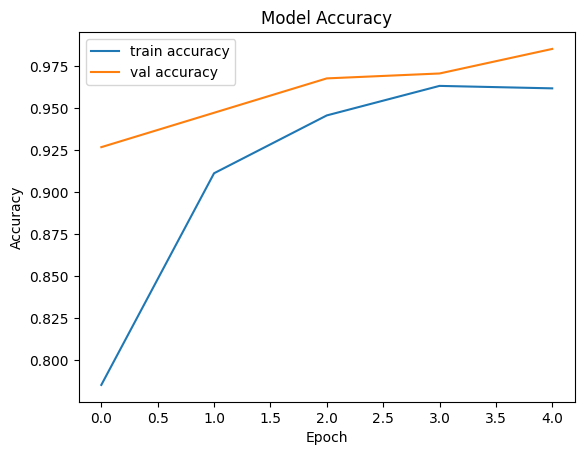

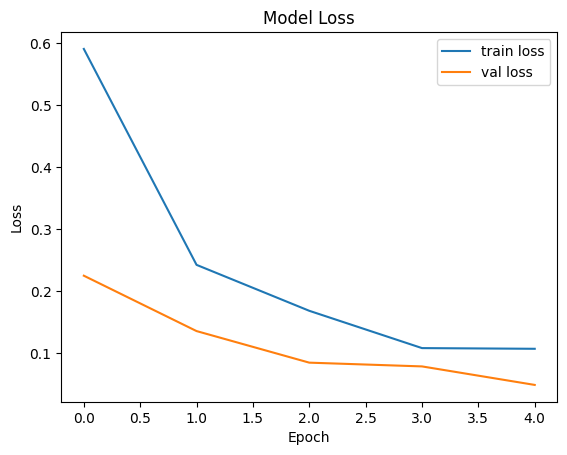

In [ ]:
import os
import numpy as np
import cv2
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


dataset_path = 'C://Users//Divisha//Desktop//dhruv study//DL project//dataset//dataset//dataset'

def load_data(dataset_path):
    images = []
    labels = []
    label_map = {'Normal': 0, 'Tumor': 1}
    
    for label in os.listdir(dataset_path):
        if label in label_map:
            for img_file in os.listdir(os.path.join(dataset_path, label)):
                img_path = os.path.join(dataset_path, label, img_file)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (128, 128))  
                images.append(image)
                labels.append(label_map[label])

    return np.array(images), np.array(labels)

def build_dual_transfer_model():
  
    input_tensor = Input(shape=(128, 128, 3))

   
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    vgg16_base.trainable = False
    vgg16_features = GlobalAveragePooling2D()(vgg16_base.output)

   
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    inception_base.trainable = False 
    inception_features = GlobalAveragePooling2D()(inception_base.output)

   
    concatenated_features = Concatenate()([vgg16_features, inception_features])

    
    x = Dense(64, activation='relu')(concatenated_features)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)  

   
    model = Model(inputs=input_tensor, outputs=output)
    
    return model

def main():
    
    X, y = load_data(dataset_path)
    X = X / 255.0  
    
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,
                                 height_shift_range=0.1, shear_range=0.1,
                                 zoom_range=0.1, horizontal_flip=True,
                                 fill_mode='nearest')

   
    model = build_dual_transfer_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

   
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

   
    history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                        validation_data=(X_test, y_test),
                        epochs=5,  
                        callbacks=[early_stopping, reduce_lr])

    # Save the model
    model.save('optimized_dual_transfer_model.keras')

   
    with open('training_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

   
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(X_test, y_test, model):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=["Normal", "Tumor", "Stone"])

    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)

    plt.matshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    evaluate_model(X_test, y_test, model)



In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

def predict_image(image_path, model_path='optimized_dual_transfer_model.keras'):
   
    model = load_model(model_path)
    
 
    img = cv2.imread(image_path)
    if img is None:
        return "Error: Image not found."
    
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    print(prediction)
    return "Tumor" if prediction[0] > 0.5 else "Normal"
W
image_path = "C://Users//Divisha//Downloads//Test_DL//Tumor- (1397).jpg"  # Replace with the path to the image to predict
prediction = predict_image(image_path)
print(f'The prediction for the image is: {prediction}')


1/1 [==============================] - 3s 3s/step
[[0.72191024]]
The prediction for the image is: Tumor
